In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from tqdm import tqdm
import matplotlib.colors as mcolors
from copy import deepcopy
from gudhi.representations import Landscape, PersistenceImage

from topofisher.input_simulators.noisy_ring import CircleSimulator

from topofisher.filtrations.numpy.alphaDTML import AlphaDTMLayer
from topofisher.filtrations.numpy.default_filtrations import RipsFiltration

from topofisher.vectorizations.numpy.custom_vectorizations import TOPK

from topofisher.vectorizations.numpy.order_statistics import OrderStatistics
from topofisher.vectorizations.numpy.vectorization_layer import VectorizationLayers
from topofisher.vectorizations.numpy.shorthand_layers import PersistenceImages, PersistenceLandscapes

from topofisher.fisher.Fisher import show_fm_and_bias, fisherFromVecs, fisherMOPED
from topofisher.fisher.imnn import FisherLayer, IMNNLayer, MopedLayer, ExtraDimLayer
from topofisher.fisher.plot_fisher_stats import plotContours2D, plotSummaryDerivativeHists, plot_derivative_convergence


from topofisher.pipelines.circle import CirclePipeline
from topofisher.pipelines.convergence_checks import fisher_estimates_wrt_step_size
from topofisher.pipelines.utils import readFromFile, writeToFile

2023-11-07 16:37:11.567100: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-07 16:37:15.020118: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Importlib

In [134]:
import importlib
import topofisher
importlib.reload(topofisher.fisher.Fisher)
importlib.reload(topofisher.fisher.imnn)
importlib.reload(topofisher.vectorizations.numpy.order_statistics)
importlib.reload(topofisher.filtrations.numpy.filtration_layers)
importlib.reload(topofisher.filtrations.numpy.alphaDTML)
importlib.reload(topofisher.input_simulators.noisy_ring)
importlib.reload(topofisher.pipelines.pipeline)
importlib.reload(topofisher.pipelines.circle)

from topofisher.input_simulators.noisy_ring import CircleSimulator

from topofisher.filtrations.numpy.alphaDTML import AlphaDTMLayer
from topofisher.filtrations.numpy.default_filtrations import RipsFiltration, AlphaFiltration

from topofisher.vectorizations.numpy.order_statistics import OrderStatistics
from topofisher.vectorizations.numpy.custom_vectorizations import TOPK
from topofisher.vectorizations.numpy.vectorization_layer import VectorizationLayers
from topofisher.vectorizations.numpy.shorthand_layers import PersistenceImages, PersistenceLandscapes

importlib.reload(topofisher.fisher.imnn)
from topofisher.fisher.imnn import IMNNLayer, FisherLayer, MopedLayer, ExtraDimLayer
from topofisher.fisher.plot_fisher_stats import plotContours2D, plotSummaryDerivativeHists, plot_derivative_convergence


from topofisher.pipelines.circle import CirclePipeline

## Rough

### AlphaComplex

In [ ]:
vectorizations = [OrderStatistics(bdp_type = "bd", is_binned = True, num_bins = [25, 5]), \
                  OrderStatistics(bdp_type = "bd", is_binned = True, num_bins = [3, 3])]

vecLayer = VectorizationLayers(vectorizations = vectorizations)
fisherLayer = MopedLayer()
circle_pipeline = CirclePipeline(ncirc= 200, nback = 20, bgmAvg = 1., n_s = 4000, n_d = 4000, \
                                 theta_fid = tf.constant([1., 0.2]), delta_theta = tf.constant([0.1, 0.02]),\
                                 filtLayer = AlphaFiltration(max_hom_dim = 2, hom_dim_list = [0, 1], show_tqdm = True),
                                 vecLayer = vecLayer, fisherLayer = fisherLayer, find_derivative = [True, True])
# circle_pipeline.run_pipeline()

#### Standard Fisher + Unbinned

In [108]:
vectorizations = [OrderStatistics(bdp_type = "d", is_binned = False), \
                 OrderStatistics(bdp_type = "bdp", is_binned = False)
                 ]

vecLayer = VectorizationLayers(vectorizations = vectorizations, pds_idx_list = [0, 1])
fisherLayer = FisherLayer()
fish = circle_pipeline.vectorize_and_fisher(vecLayer, fisherLayer)
show_fm_and_bias(fish)

log FI =  15.43
FM =  [1200.71 1049.1  1049.1  5094.95]
Fractional bias =  [0.08 0.23]
Constraints =  [0.03186765 0.01547031]


In [145]:
vectorizations = [OrderStatistics(bdp_type = "d", is_binned = False), \
                 #OrderStatistics(bdp_type = "bdp", is_binned = False)
                 ]

vecLayer = VectorizationLayers(vectorizations = vectorizations, pds_idx_list = [0])
fisherLayer = MopedLayer(compression_frac = 0.8)
fish = circle_pipeline.vectorize_and_fisher(vecLayer, fisherLayer)
show_fm_and_bias(fish)

log FI =  10.02
FM =  [ 238.83  779.07  779.07 2635.6 ]
Fractional bias =  [0.07 0.07]
Constraints =  [0.34204796 0.10296642]


In [125]:
vectorizations = [#OrderStatistics(bdp_type = "bdp", is_binned = False), \
                 OrderStatistics(bdp_type = "bp", is_binned = False)
                 ]

vecLayer = VectorizationLayers(vectorizations = vectorizations, pds_idx_list = [1])
fisherLayer = MopedLayer(compression_frac = 0.5)
fish = circle_pipeline.vectorize_and_fisher(vecLayer, fisherLayer)
show_fm_and_bias(fish)

log FI =  13.12
FM =  [ 388.24  399.33  399.33 1691.47]
Fractional bias =  [0. 0.]
Constraints =  [0.05832493 0.02794279]


In [133]:
vectorizations = [#OrderStatistics(bdp_type = "bdp", is_binned = False), \
                 OrderStatistics(bdp_type = "bp", is_binned = True, num_bins = [2,1])
                 ]

vecLayer = VectorizationLayers(vectorizations = vectorizations, pds_idx_list = [1])
# fisherLayer = MopedLayer(compression_frac = 0.5)
fisherLayer = FisherLayer()
fish = circle_pipeline.vectorize_and_fisher(vecLayer, fisherLayer)
show_fm_and_bias(fish)

log FI =  13.09
FM =  [ 336.43  642.53  642.53 2668.62]
Fractional bias =  [0. 0.]
Constraints =  [0.07418023 0.02633853]


Plotting only the first 4 dimensions. Can't plot so many               histograms for aesthetic purposes.


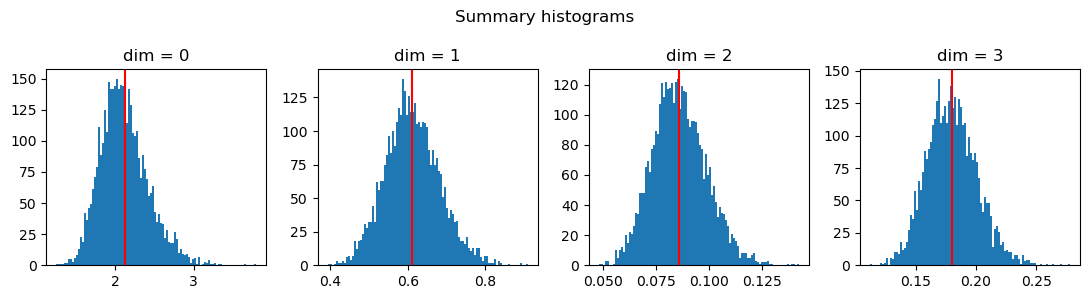

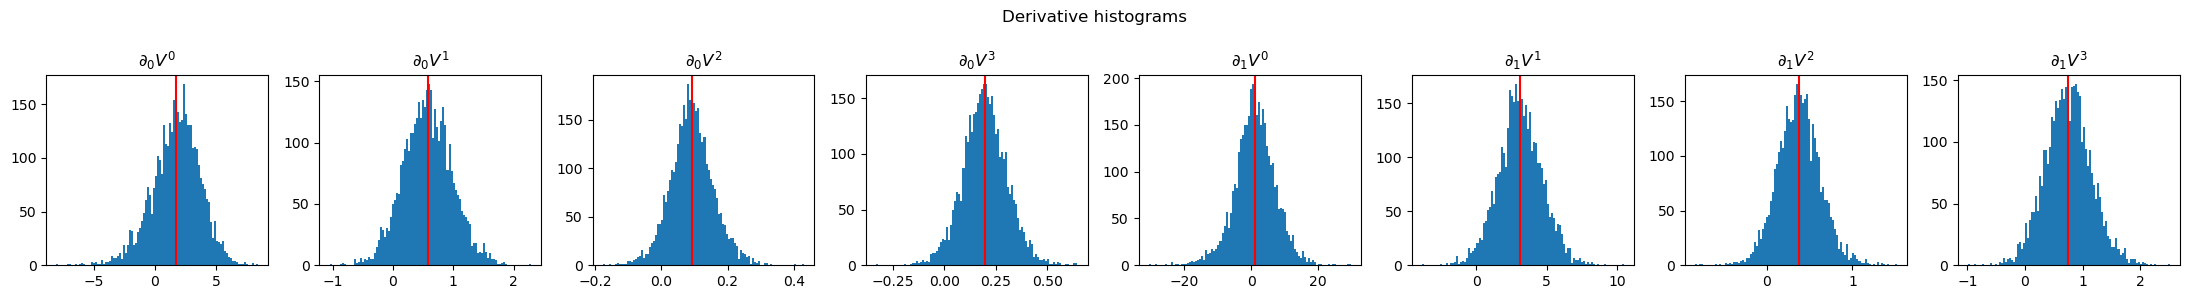

In [129]:
plotSummaryDerivativeHists(fish)

### DTMRipsComplex

In [ ]:
vectorizations = [TOPK(bdp_type = "bd", is_binned = False, topk = 109), TOPK(bdp_type = "bd", is_binned = True, topk = 11, num_bins = 5)]

vecLayer = VectorizationLayers(vectorizations = vectorizations)
fisherLayer = MopedLayer()
circle_pipeline = CirclePipeline(ncirc = 100, nback = 10, bgmAvg = 1., n_s = 100, n_d = 100, \
                                 theta_fid = tf.constant([1., 0.2]), delta_theta = tf.constant([0.01, 0.002]),\
                                 filtLayer = DTMRipsFiltration(num_nn = 100, collapse_edges = True, max_hom_dim = 2, hom_dim_list = [0, 1], show_tqdm = True),
                                 vecLayer = vecLayer, fisherLayer = None, find_derivative = [True, True])
circle_pipeline.run_pipeline(seed_cov = 1, seed_ders = [2, 3])
v1 = circle_pipeline.all_vecs

In [66]:
filtLayer = DTMRipsFiltration(num_nn = 100, collapse_edges = True, max_hom_dim = 2,\
                              hom_dim_list = [0, 1], show_tqdm = False)
stsm = filtLayer.find_simplex_trees(circle_pipeline.all_pts[1][:10])
stsp = filtLayer.find_simplex_trees(circle_pipeline.all_pts[2][:10])

In [67]:
ppsm = [item.persistence_pairs() for item in stsm]
ppsp = [item.persistence_pairs() for item in stsp]

In [75]:
simplices_m = [item.get_simplices() for item in stsm]
simplices_p = [item.get_simplices() for item in stsp]

In [74]:
idx = np.random.randint(10)
for item in ppsm[idx]:
    if item not in ppsp[idx]: print(item)
    

for item in ppsp[idx]:
    if item not in ppsm[idx]: print(item)

([51, 25], [52, 51, 32])
([56, 27], [104, 77, 51])
([73, 37], [96, 67, 19])
([51, 25], [52, 32, 25])
([56, 27], [104, 77, 49])
([73, 37], [96, 73, 60])


In [82]:
idx = np.random.randint(10)

slp = [item[0] for item in simplices_p[idx]]
slm = [item[0] for item in simplices_m[idx]]
for item in slp:
    if item not in slm: print(item)
for item in slm:
    if item not in slp: print(item)

[0, 9]
[24, 34, 99]
[28, 92]
[34, 77, 99]
[34, 99]
[24, 34, 77]
[24, 77, 99]
[24, 77]
[92, 93]


In [34]:
circle_pipeline.collect_benchmarks()
circle_pipeline.benchmarks['TFM']

array([[ 2.1339619e+03, -3.9488636e-02],
       [-3.9488636e-02,  3.4725178e+03]], dtype=float32)

In [43]:
circle_pipeline.all_persistence_diagrams[0][0][0].shape

(109, 2)

In [45]:
vectorizations = [TOPK(bdp_type = "bdp", is_binned = False, topk = 109), TOPK(bdp_type = "bdp", is_binned = False, topk = 1)]
vecLayer = VectorizationLayers(vectorizations = vectorizations)
fisherLayer = FisherLayer()
fish = circle_pipeline.vectorize_and_fisher(vecLayer, fisherLayer)
show_fm_and_bias(fish)

log FI =  15.6
FM =  [1943.89  216.04  216.04 3090.3 ]
Fractional bias =  [0.03 0.28]
Constraints =  [0.02276975 0.01805898]


In [46]:
fisherLayer = MopedLayer()
fish = circle_pipeline.vectorize_and_fisher(vecLayer, fisherLayer)
show_fm_and_bias(fish)

log FI =  12.5
FM =  [576.12  48.32  48.32 469.57]
Fractional bias =  [0.   0.02]
Constraints =  [0.04184317 0.04634812]


In [31]:
show_fm_and_bias(FisherLayer().computeFisher(circle_pipeline.all_vecs, circle_pipeline.delta_theta))

log FI =  15.15
FM =  [1849.82  249.72  249.72 2081.44]
Fractional bias =  [0.   0.03]
Constraints =  [0.02344128 0.02209852]


In [32]:
show_fm_and_bias(MopedLayer().computeFisher(circle_pipeline.all_vecs, circle_pipeline.delta_theta))

log FI =  14.83
FM =  [1745.09  171.21  171.21 1594.75]
Fractional bias =  [0. 0.]
Constraints =  [0.02406523 0.025174  ]


### Order statistics

In [ ]:
circle_pipeline = readFromFile("/Users/karthikviswanathan/Downloads/imph/circle_pipelines/pipeline_m_p9_ns_4K.pkl")

In [61]:
vectorizations = [OrderStatistics(bdp_type = "bd", is_binned = True, num_bins = [25, 5]), \
                  OrderStatistics(bdp_type = "bd", is_binned = True, num_bins = [3, 3])]

vecLayer = VectorizationLayers(vectorizations = vectorizations)
fisherLayer = MopedLayer()
circle_pipeline = CirclePipeline(ncirc= 200, nback = 20, bgmAvg = 1., n_s = 4000, n_d = 4000, \
                                 theta_fid = tf.constant([1., 0.2]), delta_theta = tf.constant([0.1, 0.02]),\
                                 filtLayer = AlphaDTMLayer(m = 0.05, max_hom_dim = 2, hom_dim_list = [0, 1], show_tqdm = True),
                                 vecLayer = vecLayer, fisherLayer = fisherLayer, find_derivative = [True, True])
circle_pipeline.run_pipeline()

100%|██████████| 4000/4000 [00:25<00:00, 157.35it/s]


#### Standard Fisher + Unbinned

In [65]:
vectorizations = [OrderStatistics(bdp_type = "bdp", is_binned = False), \
                 OrderStatistics(bdp_type = "bdp", is_binned = False)
                 ]

vecLayer = VectorizationLayers(vectorizations = vectorizations, pds_idx_list = [0, 1])
fisherLayer = FisherLayer()
fish = circle_pipeline.vectorize_and_fisher(vecLayer, fisherLayer)
show_fm_and_bias(fish)

log FI =  15.55
FM =  [1323.78 1224.54 1224.54 5392.49]
Fractional bias =  [0.08 0.2 ]
Constraints =  [0.03092387 0.01532173]


In [63]:
vectorizations = [OrderStatistics(bdp_type = "bdp", is_binned = False), \
                 #OrderStatistics(bdp_type = "bdp", is_binned = False)
                 ]

vecLayer = VectorizationLayers(vectorizations = vectorizations, pds_idx_list = [0])
fisherLayer = FisherLayer()
fish = circle_pipeline.vectorize_and_fisher(vecLayer, fisherLayer)
show_fm_and_bias(fish)

log FI =  13.91
FM =  [ 540.57 1290.59 1290.59 5108.85]
Fractional bias =  [0.34 0.42]
Constraints =  [0.06827157 0.02220774]


In [64]:
vectorizations = [#OrderStatistics(bdp_type = "bdp", is_binned = False), \
                 OrderStatistics(bdp_type = "bdp", is_binned = False)
                 ]

vecLayer = VectorizationLayers(vectorizations = vectorizations, pds_idx_list = [1])
fisherLayer = FisherLayer()
fish = circle_pipeline.vectorize_and_fisher(vecLayer, fisherLayer)
show_fm_and_bias(fish)

log FI =  14.15
FM =  [ 547.73  180.96  180.96 2601.58]
Fractional bias =  [0.01 0.06]
Constraints =  [0.04322785 0.01983489]


#### CompressedFisher

In [80]:
vectorizations = [OrderStatistics(bdp_type = "bdp", is_binned = True, num_bins = [24, 5]), \
                  OrderStatistics(bdp_type = "bdp", is_binned = False)]

vecLayer = VectorizationLayers(vectorizations = vectorizations)
fisherLayer = MopedLayer(compression_frac = 0.8)
fish = circle_pipeline.vectorize_and_fisher(vecLayer, fisherLayer)
show_fm_and_bias(fish)

log FI =  15.1
FM =  [1230.58 1044.11 1044.11 3830.04]
Fractional bias =  [0. 0.]
Constraints =  [0.03251376 0.0184298 ]


In [47]:
vectorizations = [\
                # OrderStatistics(bdp_type = "bdp", is_binned = True, num_bins = [24, 5]), \
                  OrderStatistics(bdp_type = "bdp", is_binned = False)\
                    ]

vecLayer = VectorizationLayers(vectorizations = vectorizations, pds_idx_list = [1])
fisherLayer = MopedLayer()
fish = circle_pipeline.vectorize_and_fisher(vecLayer, fisherLayer)
show_fm_and_bias(fish)

log FI =  14.12
FM =  [ 673.91  157.97  157.97 2042.54]
Fractional bias =  [0. 0.]
Constraints =  [0.03887503 0.02232993]


In [60]:
vectorizations = [\
                 OrderStatistics(bdp_type = "bdp", is_binned = False ,   num_bins = [24, 5]), \
                 # OrderStatistics(bdp_type = "bdp", is_binned = False)\
                ]
#vectorizations = [\
 #                OrderStatistics(bdp_type = "bdp", is_binned = False)
  #              ]
vecLayer = VectorizationLayers(vectorizations = vectorizations, pds_idx_list = [0])
# fisherLayer = FisherLayer()
fisherLayer = MopedLayer()
fish = circle_pipeline.vectorize_and_fisher(vecLayer, fisherLayer)
show_fm_and_bias(fish)

log FI =  12.51
FM =  [ 433.79  862.14  862.14 2339.89]
Fractional bias =  [0. 0.]
Constraints =  [0.09279265 0.03995376]


In [35]:
vectorizations = [OrderStatistics(bdp_type = "bdp", is_binned = False), \
                 OrderStatistics(bdp_type = "bdp", is_binned = False)
                 ]

vecLayer = VectorizationLayers(vectorizations = vectorizations, pds_idx_list = [0, 1])
fisherLayer = MopedLayer()
fish = circle_pipeline.vectorize_and_fisher(vecLayer, fisherLayer, False)
show_fm_and_bias(fish)

log FI =  14.11
FM =  [ 869.1   645.39  645.39 2029.72]
Fractional bias =  [0. 0.]
Constraints =  [0.03881088 0.02539629]


In [30]:
vectorizations = [OrderStatistics(bdp_type = "bdp", is_binned = False), \
                 # OrderStatistics(bdp_type = "bd", is_binned = False)
                 ]

vecLayer = VectorizationLayers(vectorizations = vectorizations, pds_idx_list = [0])
fisherLayer = FisherLayer()
fish = circle_pipeline.vectorize_and_fisher(vecLayer, fisherLayer, False)
show_fm_and_bias(fish)

log FI =  14.47
FM =  [ 767.15 1439.59 1439.59 5198.29]
Fractional bias =  [0.22 0.31]
Constraints =  [0.05209477 0.02001265]


In [33]:
vectorizations[0].topk

25

In [34]:
# circle_pipeline = readFromFile("/Users/karthikviswanathan/Downloads/imph/circle_pipelines/pipeline_m_p9_ns_4K.pkl")
vectorizations = [
                 #OrderStatistics(bdp_type = "bd", is_binned = True, num_bins = [24, 5]), \
                 OrderStatistics(bdp_type = "bdp", is_binned = False)
                 ]

vecLayer = VectorizationLayers(vectorizations = vectorizations, pds_idx_list = [1])
fisherLayer = FisherLayer()
fish = circle_pipeline.vectorize_and_fisher(vecLayer, fisherLayer, False)
show_fm_and_bias(fish)

log FI =  14.44
FM =  [ 747.01  280.01  280.01 2606.51]
Fractional bias =  [0.01 0.06]
Constraints =  [0.03734751 0.01999381]


In [52]:
circle_pipeline = readFromFile("/Users/karthikviswanathan/Downloads/imph/circle_pipelines/pipeline_m_p9_ns_4K.pkl")
vectorizations = [
                 #OrderStatistics(bdp_type = "bd", is_binned = True, num_bins = [24, 5]), \
                 OrderStatistics(bdp_type = "bd", is_binned = False)
                 ]

vecLayer = VectorizationLayers(vectorizations = vectorizations, pds_idx_list = [1])
fisherLayer = FisherLayer()
fish = circle_pipeline.vectorize_and_fisher(vecLayer, fisherLayer)
show_fm_and_bias(fish)

log FI =  15.08
FM =  [2722.09  -64.94  -64.94 1297.25]
Fractional bias =  [0.   0.08]
Constraints =  [0.01917821 0.02778094]


In [46]:
circle_pipeline = readFromFile("/Users/karthikviswanathan/Downloads/imph/circle_pipelines/pipeline_m_p9_ns_4K.pkl")
vectorizations = [
                 OrderStatistics(bdp_type = "bd", is_binned = True, num_bins = [24, 5]), \
                 OrderStatistics(bdp_type = "bd", is_binned = False)
                 ]

vecLayer = VectorizationLayers(vectorizations = vectorizations, pds_idx_list = [0, 1])
fisherLayer = FisherLayer()
fish = circle_pipeline.vectorize_and_fisher(vecLayer, fisherLayer)
show_fm_and_bias(fish)

22 197 219.0
26 26 54.0
log FI =  16.91
FM =  [4031.66  376.96  376.96 5519.52]
Fractional bias =  [0.   0.02]
Constraints =  [0.01579971 0.01350331]


## Example usage

In [3]:
circle_pipeline = readFromFile("/Users/karthikviswanathan/Downloads/imph/circle_pipelines/pipeline_m_p9_ns_4K.pkl")
fisher = circle_pipeline.fisher
show_fm_and_bias(fisher)

log FI =  16.77
FM =  [3830.37  539.6   539.6  5088.21]
Fractional bias =  [0.   0.03]
Constraints =  [0.01627976 0.01412493]


In [17]:
vectorizations = [TOPK(bdp_type = "bd", is_binned = True, topk = 219, num_bins = 25), TOPK(bdp_type = "bd", is_binned = True, topk = 29, num_bins = 5)]

vecLayer = VectorizationLayers(vectorizations = vectorizations)
fisherLayer = MopedLayer()
circle_pipeline = CirclePipeline(ncirc= 200, nback = 20, bgmAvg = 1., n_s = 4000, n_d = 1000, \
                                 theta_fid = tf.constant([1., 0.2]), delta_theta = tf.constant([0.1, 0.02]),\
                                 filtLayer = AlphaDTMLayer(m = 0.9, max_hom_dim = 2, hom_dim_list = [0, 1], show_tqdm = True),
                                 vecLayer = vecLayer, fisherLayer = fisherLayer, find_derivative = [True, True])
circle_pipeline.run_pipeline()

100%|██████████| 1000/1000 [00:07<00:00, 130.04it/s]


### Testing the Gaussian approximation

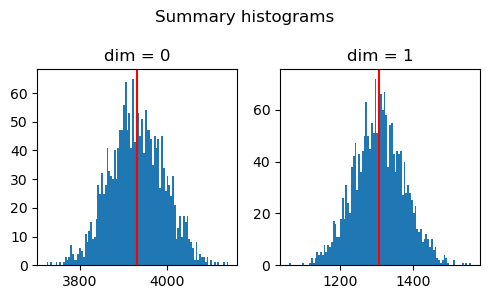

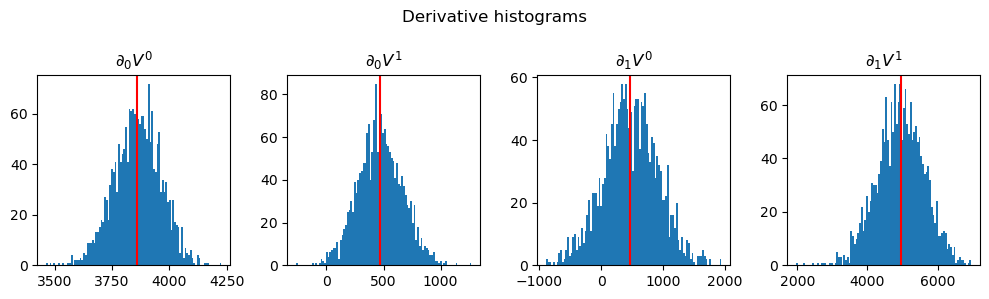

In [3]:
plotSummaryDerivativeHists(fisher)

### Testing the derivative convergence

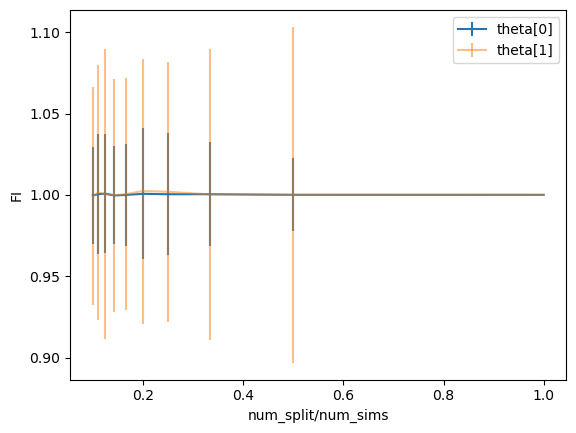

In [4]:
plot_derivative_convergence(fisher.summaries, fisher.delta_theta)

### Checking the choice of step size

In [ ]:
importlib.reload(topofisher.pipelines.convergence_checks)
from topofisher.pipelines.convergence_checks import fisher_estimates_wrt_step_size
fisher_estimates_wrt_step_size(circle_pipeline, param_idx = 0, step_list = tf.linspace(0.01, 0.2, 5), \
                               seed_cov = circle_pipeline.seed_cov, seed_ders = circle_pipeline.seed_ders)

In [8]:
circle_pipeline = readFromFile("pipeline_m_p9_ns_4K.pkl")
from gudhi.point_cloud.knn import KNearestNeighbors
knn = KNearestNeighbors(150, return_index = False, \
                    return_distance = True, \
                    enable_autodiff = True)
all_pts = circle_pipeline.all_pts
ans = knn.fit_transform(all_pts[0][0])

In [14]:
a = ans[0]
np.all(a[:-1] <= a[1:])

True

## Persistence Images

In [31]:
importlib.reload(topofisher.fisher.imnn)
from topofisher.fisher.imnn import IMNNLayer, FisherLayer, MopedLayer, ExtraDimLayer

In [ ]:
circle_pipeline_pi

In [53]:
res = 24
pi_vec_layer = PersistenceImages(resolutions = [[res, res], [res, res]], bandwidths = [3e-2, 5e-2])
circle_pipeline_pi = CirclePipeline(ncirc= 200, nback = 20, bgmAvg = 1., n_s = 10000, n_d = 10000, \
                                 theta_fid = tf.constant([1., 0.2]), delta_theta = tf.constant([0.01, 0.002]),\
                                 filtLayer = AlphaDTMLayer(m = 0.9, max_hom_dim = 2, hom_dim_list = [0, 1], show_tqdm = True),
                                 vecLayer = pi_vec_layer, fisherLayer = None, find_derivative = [True, True])
circle_pipeline_pi.run_pipeline()

100%|██████████| 10000/10000 [01:27<00:00, 114.62it/s]


In [55]:
circle_pipeline_pi.vecLayer = None
writeToFile(circle_pipeline_pi, "pipeline_m_p9_ns_10K_dtheta_p01.pkl")

In [56]:
model = tf.keras.Sequential(
    [
        ExtraDimLayer(tf.keras.layers.Conv2D(8, (3,3), padding='same', activation = "relu", input_shape=(res, res, 2))),
        ExtraDimLayer(tf.keras.layers.MaxPooling2D((2, 2), strides=2)),
        ExtraDimLayer(tf.keras.layers.Flatten()),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(2)
    ]
)

In [57]:
pi_imnn_layer = IMNNLayer(model, verbose = 1, epochs = 15, data_splits = [0.4, 0.2, 0.4], \
                            callbacks = [tf.keras.callbacks.EarlyStopping(patience = 3)])

fisher = pi_imnn_layer.computeFisher(circle_pipeline_pi.all_vecs, circle_pipeline_pi.delta_theta)

Epoch 1/15
8/8 [==============================] - 4s 404ms/step - loss: -13.8231 - val_loss: -15.5818
Epoch 2/15
8/8 [==============================] - 3s 377ms/step - loss: -15.9251 - val_loss: -16.0440
Epoch 3/15
8/8 [==============================] - 3s 361ms/step - loss: -16.2975 - val_loss: -16.2109
Epoch 4/15
8/8 [==============================] - 3s 354ms/step - loss: -16.4965 - val_loss: -16.3377
Epoch 5/15
8/8 [==============================] - 3s 369ms/step - loss: -16.6109 - val_loss: -16.4126
Epoch 6/15
8/8 [==============================] - 3s 360ms/step - loss: -16.6993 - val_loss: -16.4511
Epoch 7/15
8/8 [==============================] - 3s 371ms/step - loss: -16.7614 - val_loss: -16.4777
Epoch 8/15
8/8 [==============================] - 3s 374ms/step - loss: -16.8100 - val_loss: -16.5015
Epoch 9/15
8/8 [==============================] - 3s 369ms/step - loss: -16.8440 - val_loss: -16.5220
Epoch 10/15
8/8 [==============================] - 3s 402ms/step - loss: -16.8879 

In [77]:
fisher = pi_imnn_layer.computeFisher(tf.stack(circle_pipeline_pi.all_vecs)[:, 6000:], circle_pipeline_pi.delta_theta)
show_fm_and_bias(fisher)
fisher.C, fisher.ders, fisher.delta_theta

FM =  [3720.42  172.77  172.77 4577.06]
Fractional bias =  [0.13 0.17]


(<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[128.81935 ,  70.606995],
        [ 70.606995,  95.8849  ]], dtype=float32)>,
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[-514.7542  , -590.5668  ],
        [ 489.0966  , -126.315895]], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.01 , 0.002], dtype=float32)>)

In [ ]:
fisher_old = circle_pipeline.vectorize_and_fisher(pi_vec_layer, pi_imnn_layer)

In [76]:
show_fm_and_bias(fisher_old)
fisher_old.C, fisher_old.ders, fisher_old.delta_theta

FM =  [3144.65  147.04  147.04 4665.55]
Fractional bias =  [0.05 0.08]


(<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[130.53767,  73.29368],
        [ 73.29368,  98.14373]], dtype=float32)>,
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[-481.5877 , -549.61414],
        [ 491.81873, -124.21921]], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.1 , 0.02], dtype=float32)>)

In [75]:
tf.math.reduce_mean(fisher_old.summaries - fisher.summaries, axis = 1) 

<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[ -0.25446254,  -0.33604443],
       [ 21.521133  ,  20.402428  ],
       [-21.490107  , -28.65337   ],
       [ -4.3911715 ,   1.3794776 ],
       [  4.4670067 ,  -0.85227305]], dtype=float32)>

#### Convergence tests

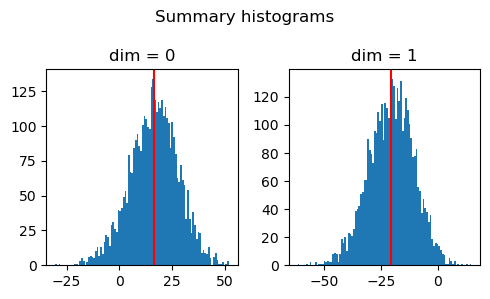

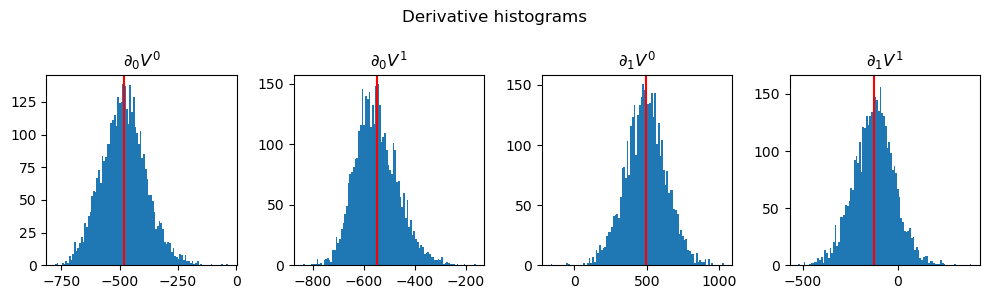

In [72]:
plotSummaryDerivativeHists(fisher_old)

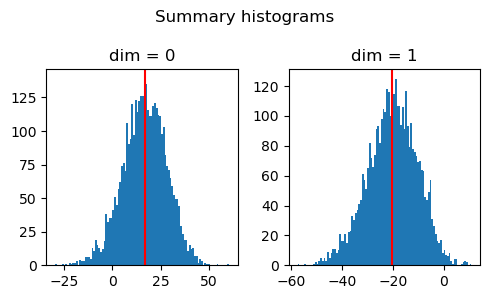

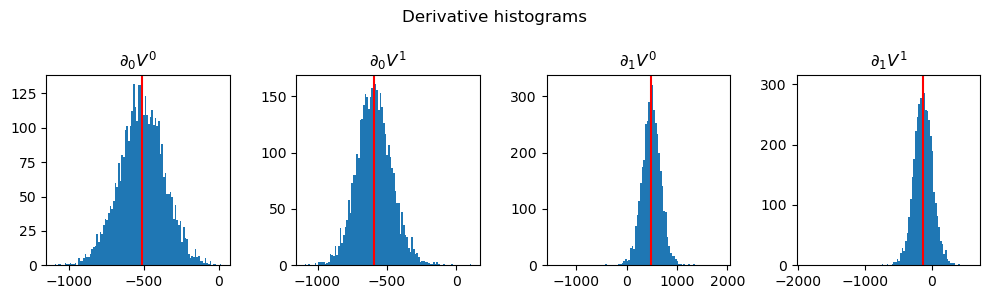

In [71]:
plotSummaryDerivativeHists(fisher)

### After weighting

In [35]:
from gudhi.representations import Landscape, PersistenceImage

In [90]:
res = 12
vectorizations = [PersistenceImage(bandwidth = 3e-2, resolution = [res, res], weight=lambda x: x[1]**2), \
                  PersistenceImage(bandwidth = 5e-2, resolution = [res, res], weight=lambda x: x[1]**2)]
pi_weighted_vec_layer = VectorizationLayers(vectorizations = vectorizations, pds_idx_list = [0, 1])
all_vecs_temp = []; 
for pds in circle_pipeline_pi.all_persistence_diagrams:
    vecs = pi_weighted_vec_layer.vectorize_persistence_diagrams(pds)
    all_vecs_temp.append(vecs)

In [ ]:
all_vecs = [pi_vec_layer.reshape_vec_to_images(item) for item in all_vecs_temp]
all_vecs = tf.stack(all_vecs)

In [39]:
all_vecs.shape

TensorShape([5, 4000, 24, 24, 2])

In [ ]:
model = tf.keras.Sequential(
    [
        ExtraDimLayer(tf.keras.layers.Conv2D(8, (3,3), padding='same', activation = "relu", input_shape=(res, res, 2))),
        ExtraDimLayer(tf.keras.layers.MaxPooling2D((2, 2), strides = 2)),
        ExtraDimLayer(tf.keras.layers.Flatten()),
        tf.keras.layers.Dense(12, activation="relu"),
        tf.keras.layers.Dense(2)
    ]
)
pi_weighted_imnn_layer = IMNNLayer(model, verbose = 1, epochs = 20, data_splits = [0.4, 0.2, 0.4], \
                            callbacks = [tf.keras.callbacks.EarlyStopping(patience = 3)])

fisher = pi_weighted_imnn_layer.computeFisher(all_vecs, circle_pipeline_pi.delta_theta)

In [61]:
show_fm_and_bias(fisher)

FM =  [3496.92   41.04   41.04 4043.23]
Fractional bias =  [0.18 0.29]


#### Convergence tests

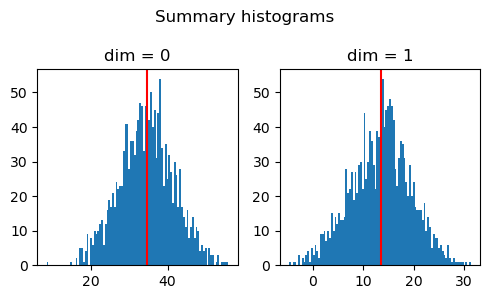

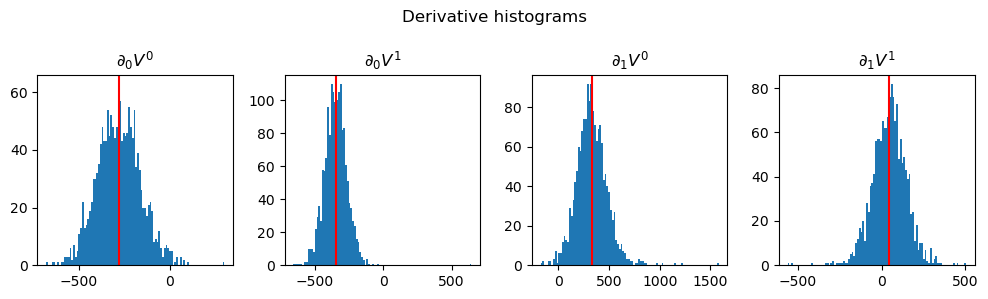

In [63]:
plotSummaryDerivativeHists(fisher)

In [ ]:
res = 24
vectorizations = [PersistenceImage(bandwidth = 3e-2, resolution = [res, res], weight=lambda x: x[1]**2), \
                  PersistenceImage(bandwidth = 5e-2, resolution = [res, res], weight=lambda x: x[1]**2)]
pi_weighted_vec_layer = VectorizationLayers(vectorizations = vectorizations)
all_vecs_temp = []
for pds in circle_pipeline.all_persistence_diagrams:
    vecs = pi_weighted_vec_layer.vectorize_persistence_diagrams(pds)
    all_vecs_temp.append(vecs)
all_vecs = [pi_vec_layer.reshape_vec_to_images(item) for item in all_vecs_temp]
all_vecs = tf.stack(all_vecs)


In [67]:
model = tf.keras.Sequential(
    [
        ExtraDimLayer(tf.keras.layers.Conv2D(8, (3,3), padding='same', activation = "relu", input_shape=(res, res, 2))),
        ExtraDimLayer(tf.keras.layers.MaxPooling2D((2, 2), strides = 2)),
        ExtraDimLayer(tf.keras.layers.Flatten()),
        tf.keras.layers.Dense(12, activation="relu"),
        tf.keras.layers.Dense(2)
    ]
)

pi_weighted_imnn_layer = IMNNLayer(model, verbose = 1, epochs = 20, data_splits = [0.4, 0.2, 0.4], \
                            callbacks = [tf.keras.callbacks.EarlyStopping(patience = 3)])
fisher = pi_weighted_imnn_layer.computeFisher(all_vecs, circle_pipeline.delta_theta)
show_fm_and_bias(fisher)

Epoch 1/20
4/4 [==============================] - 3s 354ms/step - loss: -10.2307 - val_loss: -14.3987
Epoch 2/20
4/4 [==============================] - 1s 276ms/step - loss: -14.7884 - val_loss: -15.2007
Epoch 3/20
4/4 [==============================] - 1s 272ms/step - loss: -15.4002 - val_loss: -15.5058
Epoch 4/20
4/4 [==============================] - 1s 283ms/step - loss: -15.7188 - val_loss: -15.7332
Epoch 5/20
4/4 [==============================] - 1s 273ms/step - loss: -15.9542 - val_loss: -15.8973
Epoch 6/20
4/4 [==============================] - 1s 279ms/step - loss: -16.1145 - val_loss: -16.0078
Epoch 7/20
4/4 [==============================] - 1s 269ms/step - loss: -16.2054 - val_loss: -16.1031
Epoch 8/20
4/4 [==============================] - 1s 271ms/step - loss: -16.2964 - val_loss: -16.1864
Epoch 9/20
4/4 [==============================] - 1s 284ms/step - loss: -16.3835 - val_loss: -16.2556
Epoch 10/20
4/4 [==============================] - 1s 281ms/step - loss: -16.4467 

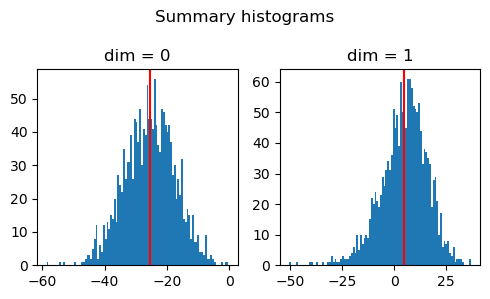

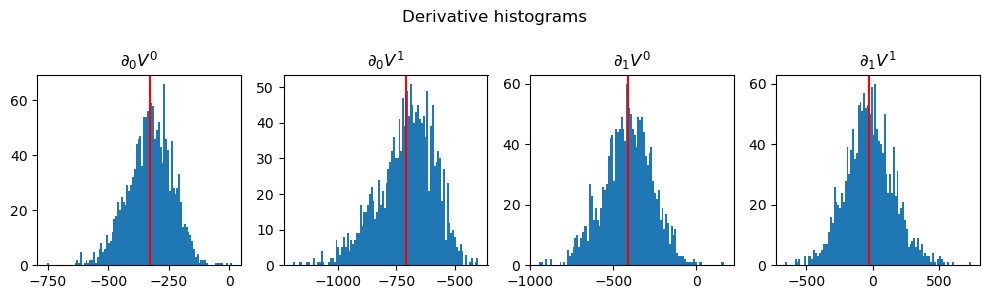

In [68]:
plotSummaryDerivativeHists(fisher)

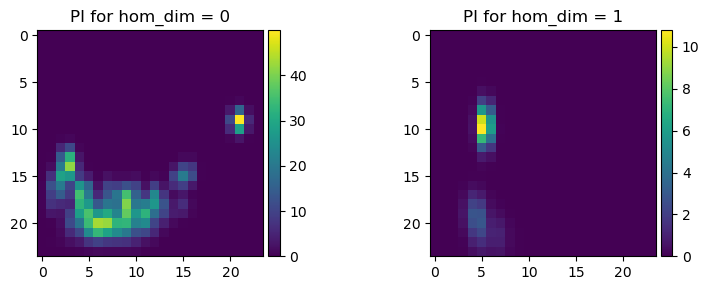

In [83]:

from mpl_toolkits.axes_grid1 import make_axes_locatable
ncols = 2
fig, axes = plt.subplots(nrows=1, ncols= ncols, \
                         figsize=(3 * ncols + 2 , 3))
pers_image = all_vecs[0, 2]
for idx in range(ncols):
    ax = axes[idx]
    im = ax.imshow(np.flip(pers_image[:, :, idx], axis = 0))
    ax.title.set_text("PI for hom_dim = " + str(idx))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
plt.tight_layout()
plt.show()

In [88]:
ind = 3
np.max(all_vecs[0, ind, :, :, 1]), np.mean(all_vecs[0, ind, :, :, 1])

(6.256615736918437, 0.1247093466686507)

In [85]:
vectorizations[1]

PersistenceImage(bandwidth=0.05,
                 im_range=array([1.03501081e+00, 3.21200657e+00, 2.38418579e-07, 7.95339227e-01]),
                 resolution=[24, 24],
                 weight=<function <lambda> at 0x7f9b08332040>)

## Concatenating

In [3]:
vectorizations = [TOPK(bdp_type = "bd", is_binned = True, topk = 219, num_bins = 25), TOPK(bdp_type = "bd", is_binned = True, topk = 29, num_bins = 5)]

vecLayer = VectorizationLayers(vectorizations = vectorizations)
fisherLayer = MopedLayer()
circle_pipeline = CirclePipeline(ncirc= 200, nback = 20, bgmAvg = 1., n_s = 10000, n_d = 10000, \
                                 theta_fid = tf.constant([1., 0.2]), delta_theta = tf.constant([0.1, 0.02]),\
                                 filtLayer = AlphaDTMLayer(m = 0.9, max_hom_dim = 2, hom_dim_list = [0, 1], show_tqdm = True),
                                 vecLayer = vecLayer, fisherLayer = fisherLayer, find_derivative = [True, True])
circle_pipeline.run_pipeline()

100%|██████████| 10000/10000 [01:21<00:00, 122.32it/s]


In [4]:
show_fm_and_bias(circle_pipeline.fisher)

FM =  [3814.2   562.56  562.56 4900.19]
Fractional bias =  [0.   0.02]


In [51]:
circle_pipeline.fisher.err

<tf.Tensor: shape=(2, 2), dtype=float64, numpy=
array([[9.14883209e+00, 4.22685132e-02],
       [4.22685132e-02, 1.09236699e+02]])>

In [ ]:
res = 24
pi_vec_layer = PersistenceImages(resolutions = [[res, res], [res, res]], bandwidths = [3e-2, 5e-2])
all_vecs = []
for pds in circle_pipeline.all_persistence_diagrams:
    vecs = pi_vec_layer.vectorize_persistence_diagrams(pds)
    all_vecs.append(vecs)

all_vecs = tf.stack(all_vecs)

In [22]:
model = tf.keras.Sequential(
    [
        ExtraDimLayer(tf.keras.layers.Conv2D(8, (3,3), padding='same', activation = "relu", input_shape=(res, res, 2))),
        ExtraDimLayer(tf.keras.layers.MaxPooling2D((2, 2), strides=2)),
        ExtraDimLayer(tf.keras.layers.Flatten()),
        tf.keras.layers.Dense(12, activation="relu"),
        tf.keras.layers.Dense(2)
    ]
)

In [23]:
pi_imnn_layer = IMNNLayer(model, verbose = 1, epochs = 8, data_splits = [0.4, 0.2, 0.4], \
                            callbacks = [tf.keras.callbacks.EarlyStopping(patience = 3)], show_bias = True)
fisher = pi_imnn_layer.computeFisher(all_vecs, circle_pipeline.delta_theta)

Epoch 1/8
8/8 [==============================] - 6s 468ms/step - loss: -11.7281 - bias0: 242.3454 - bias1: 251.4175 - val_loss: -14.3558 - val_bias0: 0.1013 - val_bias1: 0.6046
Epoch 2/8
8/8 [==============================] - 3s 319ms/step - loss: -14.7581 - bias0: 0.0971 - bias1: 0.4029 - val_loss: -14.8999 - val_bias0: 0.0747 - val_bias1: 0.2986
Epoch 3/8
8/8 [==============================] - 3s 332ms/step - loss: -15.2081 - bias0: 0.0783 - bias1: 0.2430 - val_loss: -15.2353 - val_bias0: 0.0656 - val_bias1: 0.2261
Epoch 4/8
8/8 [==============================] - 3s 348ms/step - loss: -15.5186 - bias0: 0.0688 - bias1: 0.1896 - val_loss: -15.5417 - val_bias0: 0.0593 - val_bias1: 0.1818
Epoch 5/8
8/8 [==============================] - 3s 330ms/step - loss: -15.7901 - bias0: 0.0633 - bias1: 0.1552 - val_loss: -15.7942 - val_bias0: 0.0556 - val_bias1: 0.1515
Epoch 6/8
8/8 [==============================] - 3s 330ms/step - loss: -16.0303 - bias0: 0.0603 - bias1: 0.1333 - val_loss: -16.009

In [24]:
show_fm_and_bias(fisher)

FM =  [3385.78  -21.36  -21.36 3574.07]
Fractional bias =  [0.06 0.12]


In [25]:
pi_vecs = fisher.summaries

In [26]:
pi_vecs.shape

TensorShape([5, 4000, 2])

In [29]:
moped_vecs = tf.stack(circle_pipeline.fisher.summaries)

In [35]:
moped_vecs[:, -4000:, :].shape

TensorShape([5, 4000, 2])

In [36]:
concat_vecs = np.concatenate([moped_vecs[:, -4000:, :], pi_vecs], axis = -1)

In [42]:
import topofisher
fisher = topofisher.fisher.Fisher.fisherFromVecs(concat_vecs, circle_pipeline.delta_theta)

In [43]:
show_fm_and_bias(fisher)

FM =  [3923.19  505.57  505.57 5117.17]
Fractional bias =  [0.16 0.29]


In [48]:
pi_vec_layer.vectorizations[0].im_range_fixed_

array([9.11796629e-01, 2.29350066e+00, 5.72204590e-06, 9.49870586e-01])

In [49]:
pi_vec_layer.vectorizations[1].im_range_fixed_

array([9.89345193e-01, 3.25344276e+00, 1.19209290e-07, 8.49098444e-01])